In [7]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath

import seaborn as sns
sns.set()
sns.set_style("white")


import sys
sys.path.append('../../')

import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import neuro_shooting
from neuro_shooting.shooting_models import AutoShootingIntegrandModelUpDown as UpDown
from neuro_shooting.shooting_models import AutoShootingIntegrandModelDampenedUpDown as UpDownDamp
from neuro_shooting.shooting_models import AutoShootingIntegrandModelSimple as Simple
from neuro_shooting.shooting_models import AutoShootingIntegrandModelSecondOrder as SecOrder
from neuro_shooting.shooting_blocks import ShootingBlockBase as Base
import neuro_shooting.parameter_initialization as pi

from utils import ConcentricSphere, dataset_to_numpy, sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
data_dim = 2
train_data = ConcentricSphere(data_dim, 
                              inner_range=(0., .5), 
                              outer_range=(1., 1.5), 
                              num_points_inner=1000, 
                              num_points_outer=2000)

test_data = ConcentricSphere(data_dim, 
                             inner_range=(0., .5), 
                             outer_range=(1., 1.5), 
                             num_points_inner=1000, 
                             num_points_outer=2000)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [9]:
def plot_data(X, y):
    plt.figure(figsize=(6,6))
    plt.plot(X[np.where(y==0)[0],0], X[np.where(y==0)[0],1],'.', color='red',  label='0', alpha=0.5)
    plt.plot(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1],'.', color='blue', label='1', alpha=0.5)
    plt.axis('equal');
    plt.legend();

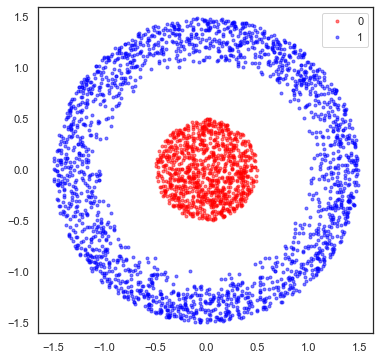

In [10]:
train_data_np, train_targets_np = dataset_to_numpy(train_loader)
plot_data(train_data_np, train_targets_np)

In [24]:
# class Model(nn.Module):
#     def __init__(self, nr_of_particles=10, parameter_weight=1.0, inflation_factor=5):
#         super(Model, self).__init__()

#         kwargs = {'in_features': 2,
#                   'nonlinearity': 'relu',
#                   'nr_of_particles': nr_of_particles,
#                   'parameter_weight': parameter_weight,
#                   'inflation_factor': inflation_factor,
#                   'costate_initializer' : pi.VectorEvolutionParameterInitializer(
#                        random_initialization_magnitude=0.5)}
        
#         self.int = UpDown(**kwargs, use_analytic_solution=True)
#         self.blk = Base('Model', 
#                         shooting_integrand=self.int,
#                         integrator_name = 'rk4',
#                         integrator_options = {'step_size': 0.1})
#                         #integrator_name = 'dopri5',
#                         #integrator_options = {'max_num_steps': 1000})
#         self.cls = nn.Sequential(nn.BatchNorm1d(2), nn.Linear(2,1,bias=False))
        
#     def trajectory(self, x, N=10):
#         t = torch.linspace(0., 1., N)
#         self.blk.set_integration_time_vector(t, suppress_warning=True)
#         out = self.blk(x)
#         self.blk.set_integration_time(1.)   
#         return out
              
#     def forward(self, x):
#         z,_,_,_ = self.blk(x)
#         x = self.cls(z.view(z.size(0),-1))
#         return z, x

In [12]:
# def train(model, device, train_loader, optimizer, epoch, norm_penalty_weight=0.0, track=True):
#     model.train()
#     epoch_loss = 0
#     Z = []
#     y = []
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         z, output = model(data.unsqueeze(1))            
#         loss = F.binary_cross_entropy_with_logits(output, target) + norm_penalty_weight * model.blk.get_norm_penalty()
#         epoch_loss += loss.item()
#         loss.backward()
#         optimizer.step()
        
#         if track:
#             Z.append(z.detach().cpu().squeeze().numpy())
#             y.append(target.detach().cpu().numpy())

#     return epoch_loss / len(train_loader), np.vstack(Z), np.vstack(y)

In [13]:
# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             _, output = model(data.unsqueeze(1))
#             test_loss += F.binary_cross_entropy_with_logits(output, target, reduction='sum').item()
#             pred = torch.sigmoid(output).round()
#             correct += pred.eq(target.view_as(pred)).sum().item()
            
#     return test_loss/len(test_loader.dataset), 100. * correct / len(test_loader.dataset)

In [17]:
# def linear_transform_hook(module, t, state_dicts, costate_dicts, data_dict_of_dicts,
#             dot_state_dicts, dot_costate_dicts, dot_data_dict_of_dicts, parameter_objects, custom_hook_data):

#     with torch.no_grad():
#         custom_hook_data['t'].append(t.item())
#         custom_hook_data['q1'].append(state_dicts['Model']['q1'].clone())
#         custom_hook_data['l1_weight'].append(parameter_objects['l1']._parameter_dict['weight'].clone())
#         custom_hook_data['l1_bias'].append(parameter_objects['l1']._parameter_dict['bias'].clone())
#         custom_hook_data['l2_weight'].append(parameter_objects['l2']._parameter_dict['weight'].clone())
#         custom_hook_data['l2_bias'].append(parameter_objects['l2']._parameter_dict['bias'].clone())

In [15]:
# def hook_in(model, device, loader):
#     model.eval()
#     custom_hook_data = defaultdict(list)
#     hook = model.blk.shooting_integrand.register_lagrangian_gradient_hook(linear_transform_hook)
#     model.blk.shooting_integrand.set_custom_hook_data(data=custom_hook_data)
#     with torch.no_grad():
#         for data, target in loader:
#             data, target = data.to(device), target.to(device)
#             _, output = model(data.unsqueeze(1))  
#             break
#     hook.remove()
#     return custom_hook_data

In [18]:
# device = 'cpu'

# tracker = []

# model = Model(nr_of_particles=4, parameter_weight=1., inflation_factor=5)

# B = next(iter(train_loader))
# model(B[0].unsqueeze(1));

# optimizer = torch.optim.Adam([
#         {'params': model.blk.parameters()},
#         {'params': model.cls.parameters(), 'weight_decay': 1e-2}],
#         lr=5e-2)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)
# for epoch in range(10):
    
#     train_loss, _, _ = train(
#         model, 
#         device, 
#         train_loader, 
#         optimizer, 
#         epoch, 
#         1e-3,
#         False)
    
#     test_loss, correct = test(
#         model, 
#         device, 
#         test_loader)
    
#     tracker.append(hook_in(model, device, train_loader))
#     scheduler.step()
    
#     print('{:4d} | train-loss {:.4f} | test-loss {:.4f} | correct: {:.2f} [%]'.format(
#         epoch, train_loss, test_loss, correct))

In [19]:
# from scipy import interpolate

def particle_viz(tracker, epoch=-1):

    plt.figure(figsize=(4,4))
    plt.title('Particles [Epoch {}] from [0,1]'.format(epoch))
    assert len(tracker) > 0 and (epoch < len(tracker) or epoch == -1)
    assert isinstance(tracker[-1], defaultdict)
    
    t_org = tracker[epoch]['t']
    t_idx = np.argsort(t_org)
    
    for p_id in range(tracker[epoch]['q1'][0].size(0)):
        p = np.vstack([tracker[epoch]['q1'][t][p_id].squeeze().numpy() for t in t_idx])
        plt.plot(p[: ,0],p[:, 1], '-', lw=3)
        plt.plot(p[-1,0],p[-1,1], '.', color='black')
        plt.plot(p[0, 0],p[0, 1], '.', color='red')
    plt.grid()
    
#particle_viz(tracker)

In [20]:
def layer_stats(tracker, quantity, epoch=-1):
    from numpy.linalg import svd

    plt.figure(figsize=(4,2))
    plt.title('Layer {} stats from [0,1]'.format(quantity))
    assert len(tracker) > 0 and (epoch < len(tracker) or epoch == -1)
    assert isinstance(tracker[-1], defaultdict)
    
    t_org = tracker[epoch]['t']
    t_idx = np.argsort(t_org)
    
    stats = defaultdict(list)
    for t in t_idx: 
        U,S,V = svd(tracker[epoch][quantity][t])
        stats['nuc'].append(np.max(S)) # Lipschitz constant
        stats['fro'].append(tracker[epoch][quantity][t].norm().item())
    
    plt.plot(np.array(t_org)[t_idx], stats['nuc'], label='Nuc.', lw=3)
    plt.plot(np.array(t_org)[t_idx], stats['fro'], label='Fro.', lw=3)
    plt.legend()
    plt.xlabel('Time')
    plt.grid()

In [21]:
def plot_trajectory(model, data, N):
    sample_ds = sample(data, N)
    sample_dl = DataLoader(sample_ds, batch_size=32, shuffle=False)
    
    trajectory_X = []
    trajectory_y = []

    for data, target in sample_dl:
        out,_,_,_ = model.trajectory(data.unsqueeze(1), 50)
        trajectory_X.append(out.detach().cpu())
        trajectory_y.append(target.detach().cpu())    
    trajectory_X = torch.cat(trajectory_X,dim=1).numpy()
    trajectory_y = torch.cat(trajectory_y,dim=0).numpy()
    
    alpha = 0.5

    plt.figure(figsize=(4,4))
    for i in range(trajectory_y.shape[0]):
        r = trajectory_X[:,i,::].squeeze()
        c = 'red' if trajectory_y[i,0]==0 else 'blue'
        plt.scatter(r[-1,0],r[-1,1],color=c, alpha=alpha, s=5)
        plt.plot(r[:,0],r[:,1],'-', color=c, alpha=alpha, lw=1)
    plt.axis('equal');
    plt.title('Trajectories', fontsize=12)
    plt.grid()

In [22]:
from matplotlib.colors import LinearSegmentedColormap

def input_space_plt(model):
    cm = plt.cm.RdBu

    x_min, x_max = -2, 2
    y_min, y_max = -2, 2 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    data = torch.tensor(np.c_[
        xx.ravel(), 
        yy.ravel()], dtype=torch.float32).unsqueeze(1)
    model.eval()
    _, predictions = model(data)
    
    colors = [(1, 1, 1), (0, 0, 1), (0.5, 0, 0.5), (1, 0, 0), (1, 1, 1)]
    colors.reverse()
    colormap = LinearSegmentedColormap.from_list('cmap_red_blue', colors, N=300)
    zz = predictions.detach().numpy().reshape(xx.shape)
    
    plt.figure(figsize=(4,4))
    plt.imshow(zz, cmap=colormap, alpha=0.75)
    plt.title('Decision boundary', fontsize=12)
#     plt.tick_params(axis='both', which='both', bottom=False, top=False,
#                         labelbottom=False, right=False, left=False,
#                         labelleft=False)
    plt.grid(False)
    plt.axis('equal')
    
#     import scipy.ndimage
#     from scipy.ndimage.filters import gaussian_filter
#     plt.figure(figsize=(6,6))
#     #zz = gaussian_filter(zz, 2)
#     plt.imshow(zz, extent=[-2, 2, -2, 2], origin='lower',
#         cmap='RdBu', alpha=0.9)
#     plt.title('Decision bondary', fontsize=12)

In [23]:
import pickle
import glob

l = glob.glob('model/model*')
for fn in l: print(fn)
def show(name):
    with open('model/' + name + '.pkl', 'rb') as f: 
        args, tracker =pickle.load(f)
    model = torch.load('model/' + name + '.pt')
    print('#Parameters', np.sum([p.numel() for p in model.parameters()]))
    print('Cls-norm:', model.cls[1].weight.norm())

    particle_viz(tracker)
    layer_stats(tracker, 'l1_weight')
    layer_stats(tracker, 'l2_weight')
    plot_trajectory(model, test_data, 150)
    input_space_plt(model)

In [ ]:
show('model_debug_20_5.0_1e-3')